# Funciones

In [100]:
# Para instalar el paquete:
# %pip install uncertainties

import numpy as np
import uncertainties as un
from uncertainties.umath import sin as unsine
from uncertainties.umath import fabs
from uncertainties import unumpy
import os 
from datetime import datetime
from IPython.display import clear_output
import matplotlib.pyplot as plt
import pandas as pd

## La función split redondeado agarra un nunmero de la forma ufloat
## y te devuelve su error a una cifra significativa y su valor nominal 
## con la misma cantidad de cifras.
def split_redondeado(x,tipo):
    # Usar str() con formato especial si está disponible

    if (tipo == "str"):
        s = f"{x:.1u}"
    # Separar en valor nominal y error
        valor_str, error_str = s.split("+/-")
        return [valor_str,error_str]
    elif (tipo == "float"):
        n = len(x)
        for i in range(n):
            x[i] = un.ufloat_fromstr(f"{x[i]:.1u}")
        return x


## La función deg2ra toma un valor tito en la forma = [°,',''] 
## y te lo pasa a titoradianes con un error de +-15''
def deg2ra(tito,error_angulo):
    tito_total = tito[0]+tito[1]/60+ tito[2]/3600
    return un.ufloat(tito_total,error_angulo/3600) * np.pi/180

## La función lam toma un valor de ángulo en grados, la amplitud de la rendija y el número m
def lam(tito,error_angulo,tito_0,d,m):
    tito_0_rad = deg2ra(tito_0,error_angulo)
    lambdas = np.array([unsine(fabs(tito_0_rad-deg2ra(valor,error_angulo)))*d/m for valor in tito])
    return split_redondeado(lambdas,"float")

def registrar_angulo(mensaje,centinela,i):
    while True:
        entrada = input(f"Ingresar el valor del ángulo {i} en la forma a°,b',c'' (SEPARADO POR COMAS) "+mensaje)
        try:
            angulo = [float(i) for i in entrada.split(",")]
            print(f"Su valor del ángulo es {angulo[0]}° {angulo[1]}' {angulo[2]}''")
            break
        except ValueError:
            if entrada in centinela:
                return entrada
            else:
                print("Hubo un error, intente de nuevo y tenga cuidado con las comas")
    return angulo

def registrar_lambda(mensaje,centinela):
    while True:
        entrada = input("Ingresar el valor de lambda en nm "+mensaje)
        try:
            lambdas = float(entrada)
            print(f"Su valor de lambda es {lambdas} nm")
            break
        except ValueError:
            if entrada in centinela:
                return entrada
            else:
                print("Hubo un error, intente de nuevo y tenga cuidado con las comas")    
    return lambdas

## Esta función crea la matriz de los datos
def medicion(error):

    # En esta lista se van a almacenar todos los valores de los angulos en grados
    Lista = []


    # La variable i es el contador de la medición.
    i=0
    
    while True:
        
        i+=1
        # La lista "angulo_grados" sirve para guardar los °,','' del ángulo dato.
        angulo_grados = registrar_angulo("Presione [S] para salir o [E] para rehacer el ángulo anterior","sSEe",f"N° {i}")  
        
        if str(angulo_grados) in "sS":
            i-=1
            print(f'se terminaron tomando N°{i} mediciones')
            break
        elif str(angulo_grados) in "eE":
            i-=2
            Lista.pop()
        else:
        # Adjuntar el valor
            Lista.append([*angulo_grados,error])  
    
    # Paso todo a un array
    return np.reshape(np.array(Lista),(i,4))

## La función guardar_csv guarda los datos en un .csv con el nombre elegido 
def guardar_csv(matriz, nombre_elemento, columnas,m=0):
    n = np.shape(matriz)[0]
    ruta = nombre_elemento 
    # Verificar si la carpeta existe
    if not os.path.exists(ruta):
        os.makedirs(ruta)  

#Lo que hace la variable nombre_archivo es:
#                    carpeta / nombre del elemento _ Lambda o Grados .csv 
    if m==0: #Grados
        nombre_archivo = os.path.join(ruta, f"{nombre_elemento}_Angulo_Grados.csv")
    elif m>0: #Lambda
        nombre_archivo = os.path.join(ruta, f"{nombre_elemento}_Lambda_m={m}.csv")
    else: 
        nombre_archivo = os.path.join(ruta, f"{nombre_elemento}_Lambda.csv")
        
    df = pd.DataFrame(matriz)
    df.columns = columnas
    df.set_axis([f"N°{i}" for i in range(n)])
    df.to_csv(nombre_archivo)
    


## Esta función se va a encargar de escribir la metadata del experimento
def metadatos(tito_0, nombre_elemento,cant_rendijas,maximo,error):
    # fecha[0] es el año fecha[1] es el mes y fecha[2] es el día
    fecha = datetime.today().strftime("%Y-%m-%d").split("-")
    ruta = nombre_elemento
    # Verificar si la carpeta existe

    nombre_archivo = os.path.join(ruta, "Metadatos" + "_" + nombre_elemento + "_" + fecha[2] + "-" + fecha[1] + "-" +fecha[0]+".csv")
    Datos = np.array([fecha,tito_0,[error,None,None],[nombre_elemento,None,None],[cant_rendijas,None,None],[maximo,None,None]])
    df = pd.DataFrame(Datos)
    df.set_axis([ "Fecha","Tito_0","Error angular [seg/arc°]","Nombre","Rendijas por mm", "Cant. máximos"])
    df.to_csv(nombre_archivo)

def check():
    """Muestra los elementos registrados y permite elegir uno.
       Devuelve el nombre de la carpeta seleccionada."""
    carpetas = [d for d in os.listdir() if os.path.isdir(d) and d.startswith("Lab_2_")]
    if not carpetas:
        print("No hay datos registrados todavía.")
        return "Nada"
    
    print("Elementos disponibles:")
    for i, carpeta in enumerate(carpetas, start=1):
        print(f"({i}) {carpeta}")
    
    while True:
        try:
            eleccion = int(input("Ingrese el número del elemento que desea revisar: "))
            if 1 <= eleccion <= len(carpetas):
                return carpetas[eleccion-1]
            else:
                print("Número inválido, intente de nuevo.")
        except ValueError:
            print("Entrada inválida, por favor ingrese un número.")

def mostrar_datos(Nombre,tipo):
    """Lee e imprime la metadata de un elemento"""
    archivos = [f for f in os.listdir(Nombre) if tipo in f]
    if not archivos:
        print(f"No se encontró archivo de {tipo} en esta carpeta.")
        return "Tutturuu"
    archivo = os.path.join(Nombre, archivos[0])
    df = pd.read_csv(archivo)
    display(df)
    return df


# -----------------------------
# 1) Función para mapear λ -> RGB
#    (aproximación práctica, devuelve RGB en [0..1])
# -----------------------------
def wavelength_to_rgb(wavelength, gamma=0.8):
    """
    wavelength: nm (float)
    returns: (r,g,b) each in [0,1]
    Fuente: implementación estándar tipo 'wavelen2rgb' usada en muchos ejemplos.
    """
    wl = float(wavelength)
    if wl < 380 or wl > 750:
        return (0.0, 0.0, 0.0)

    if wl < 440:
        r = -(wl - 440) / (440 - 380)
        g = 0.0
        b = 1.0
    elif wl < 490:
        r = 0.0
        g = (wl - 440) / (490 - 440)
        b = 1.0
    elif wl < 510:
        r = 0.0
        g = 1.0
        b = -(wl - 510) / (510 - 490)
    elif wl < 580:
        r = (wl - 510) / (580 - 510)
        g = 1.0
        b = 0.0
    elif wl < 645:
        r = 1.0
        g = -(wl - 645) / (645 - 580)
        b = 0.0
    else:
        r = 1.0
        g = 0.0
        b = 0.0

    # factor near edges (human eye sensitivity)
    if wl < 420:
        factor = 0.3 + 0.7 * (wl - 380) / (420 - 380)
    elif wl > 645:
        factor = 0.3 + 0.7 * (750 - wl) / (750 - 645)
    else:
        factor = 1.0

    r = (r * factor) ** gamma
    g = (g * factor) ** gamma
    b = (b * factor) ** gamma
    return (max(0, r), max(0, g), max(0, b))

# -----------------------------
# 2) Plotter de líneas de emisión coloreadas
#    - wavelengths: iterable de nm
#    - errors: iterable de medias absolutas en nm (opcional)
#    - save_svg: ruta para guardar .svg (opcional)
# -----------------------------
def plot_emission_lines(lambdas,tipo,errors=None, title="Espectro", save_svg=None,
                         figsize=(10,3)):
    un_lam=[]
    if errors is None:
        if tipo is str:
            for L in lambdas:
                un_lam.append(un.ufloat_fromstr(L))
            un_lam = np.array(un_lam)
            wavelengths = unumpy.nominal_values(un_lam)
            errors = unumpy.std_devs(un_lam)
        else:
            wavelengths = unumpy.nominal_values(lambdas)
            errors = unumpy.std_devs(lambdas)
    else:
        wavelengths = lambdas

    Plot_option = input("Ingrese el número de mediciones que desea graficar. Separadas por comas individualmente, para todas presione [T]") 
    indices = [i for i in range(len(wavelengths))]
    Quitar = [int(a) for a in Plot_option.split(",")]
    if not str(Plot_option) in "tT":
        indices = [i for j, i in enumerate(indices) if j+1 not in Quitar]
        wavelengths = np.delete(wavelengths,indices)
        errors = np.delete(errors,indices)
        
    xlim = (min(wavelengths)-2*max(errors),max(wavelengths)+2*max(errors))
    fig, ax = plt.subplots(figsize=figsize, facecolor='black')
    ax.set_facecolor('black')
    ax.set_xlim(*xlim)
    # dejamos un pequeño espacio abajo para la barra de color
    ax.set_ylim(-0.12, 1.0)
    ax.set_yticks([])
    ax.set_xlabel("Longitud de onda (nm)", color="white")
    ax.set_title(title, color="white")

    # dibujar bandas de error (rellenas, semitransparentes)
    for lam, err in zip(wavelengths, errors):
        col = wavelength_to_rgb(lam)
        if err > 0:
            ax.fill_betweenx([0,0.95], lam - err, lam + err, color=col, alpha=0.18, linewidth=0)

    # dibujar las líneas centrales
    for lam in wavelengths:
        col = wavelength_to_rgb(lam)
        ax.axvline(lam, color=col, linewidth=1.5, alpha=0.95, zorder=3)


    # eje y invisible, texto blanco en x
    ax.tick_params(axis='x', colors='white')
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.spines['bottom'].set_color('white')

    plt.tight_layout()

    if save_svg:
        # guardar respetando el color de fondo
        fig.savefig(save_svg, format='svg', facecolor=fig.get_facecolor(), dpi=300)

    plt.show()


def registrar_datos(Tipo="Espectrometro"):
    if Tipo == "Espectrometro":
        error_angulo = float(input("Ingrese el error del instrumento en segundos de arco"))
        tito_0 = registrar_angulo("","ħ","tito_0")

        ## Empezamos con el nombre del elemento al que le medimos las lineas
        Nombre = "Lab_2_"+ input("ingrese el nombre del elemento")
        ## Ancho de las rendijas 
        n = float(input("ingrese la cantidad de líneas por milímetro que posee la rendija de difracción")) 
        # 1 000 000 [nm] entre n líneas es la distancia entre rendijas con un 1% de error
        d = un.ufloat(1000000/n,10000/n)
        ## Usamos el máximo principal
        m = int(input("ingrese el máximo que va a medir m:1,2,3,... "))
        while m<=0:
            m = int(input("Ingrese un m entero mayor que 0"))
        
        

        # Inicio el programa de adquisición de angulos y transformación a radianes
        Angulos = medicion(error_angulo)
        
        ## Hacer el calculo para el lambda
        Lambda_medido = lam(Angulos,error_angulo,tito_0,d,m)
        
        guardar_csv(Angulos,Nombre,["Grados","Minutos","Segundos","error seg/arc°"])
        metadatos(tito_0,Nombre,n,m,error_angulo)
        return Nombre,Lambda_medido
    else:
        Nombre = input("ingrese el nombre del elemento")
        Nombre = "Lab_2_"+Nombre
        error  = float(input("Ingrese la incertidumdre de las mediciones en nm"))
        Lambdas = []
        while True:

            Lam = registrar_lambda("presione [s] para terminar de registrar o [e] para rehacer la entrada anterior","sSeE")
            if str(Lam) in "sS":
                Lambdas = np.array(Lambdas)
                break   
            elif str(Lam) in "eE":
                Lambdas.pop()
            else:
                Lambdas.append(un.ufloat(float(Lam),error))
        return Nombre,split_redondeado(Lambdas,"float")


def Pumita_v3_1415():
    print("Tutturuu~!")
    salir = True
    while salir:
        Yes_No = input("Desea ingresar nuevos datos (0), revisar datos ya escritos (1), salir (2)")
        if Yes_No in "0":
            Tipo_registro = input("Los datos registrados son del espectrómetro (0), un espectro tabulado (1)")
            if Tipo_registro in "0":
                Nombre,Lambda_medido = registrar_datos()       
                clear_output()
                ## Mostrar resultados
                print("="*39)
                print(" Mediciones de los Ángulos en grados")
                print("="*39)
                mostrar_datos(Nombre,"Angulo")
            else:
                Nombre,Lambda_medido = registrar_datos("Tablas")
                Nombre+="_Tabulado"
                clear_output()
            
            guardar_csv(Lambda_medido,Nombre,["(Lambda +/- Error) nm"],-1)

           
        elif Yes_No in "1":
            Nombre = check()    
            clear_output()
            mostrar_datos(Nombre,"Metadatos")
        
        else:
            break

        print("="*32)
        print(" Resultados de los Lambda en nm")
        print("="*32)
        df_lambdas = mostrar_datos(Nombre,"Lambda")
        MAs_PLOTS = "y"
        while True:
            i=0
            
            if MAs_PLOTS in "yY":
                archivo_svg = os.path.join(Nombre, f"{Nombre}_espectro_{i}.svg")
                Titulo = Nombre.replace("Lab_2_","").replace("_"," ")
                plot_emission_lines(df_lambdas["(Lambda +/- Error) nm"].to_numpy(),str, title=f"Espectro de {Titulo}",save_svg=archivo_svg)
                MAs_PLOTS = str(input("Desea hacer más gráficos?[Y/N]"))
                i+=1
            else:
                break
    print("gracias por usar Pumita v3.1415")



# Funcionamiento principal


## Update 3.1:
- Ahora la función Pumita v3.1 te pide directamente el valor de tito_0
- Guarda datos extra en un csv como la fecha, el m usado, la cantida de rendijas y el valor de tito_0 en grados

Para que funcione el codigo debes ejecutar las dependencias, las funciones y la celda de abajo.

## Update 3.14
- Ahora puedes acceder a los datos mediante una interfaz gráfica en la salida de comandos

## Update 3.141
- Ahora se pueden hacer gráficas
- Opcion de guardar espectros tabulados

## Update 3.1415
- Completar
### ¿Qué hace?
Muchas cosas.
~~Antes de empezar ES IMPORTANTE modifificar~~ el valor de tito_0 que sería tu 0 angular.

El programa pide diferente mediciones del ángulo en la forma x° y' z'' y la transforma a radianes con una incertdumbre por defecto de 15''.

Luego, guarda los resultados en un csv en una carpeta con el nombre del elemento.

Luego, hace los cálculos de $\lambda$ ~~teniendo como predeterminado m = 1~~ y hace el mismo procedimiento de guardado que para los ángulos.

Para acceder a los datos hay dos opciones:
- Usar la variable Lambda_medido con la función split_redondeado(Lambda_medido[i],"ufloat")
- ~~Acceder desde el csv usando una función que no quise hacer~~ así que si de casualidad la haces estaría muy agradecido que la subas a https://github.com/FabriTape/Exp-2-Lab-2-Emision-de-gases-
- Ahora la función ya existe y esta integrada en el funcionamiento de Pumita v3.141

,Unnamed: 0,0,1,2
0,0,2025,9.0,10.0
1,1,216.0,20.0,15.0
2,2,15.0,NaN,NaN
3,3,Lab_2_He,NaN,NaN
4,4,300.0,NaN,NaN
5,5,1,NaN,NaN


 Resultados de los Lambda en nm


,Unnamed: 0,(Lambda +/- Error) nm
0,0,425+/-4
1,1,445+/-4
2,2,445+/-4
3,3,464+/-5
4,4,483+/-5
5,5,502+/-5
6,6,502+/-5
7,7,579+/-6
8,8,674+/-7
9,9,693+/-7


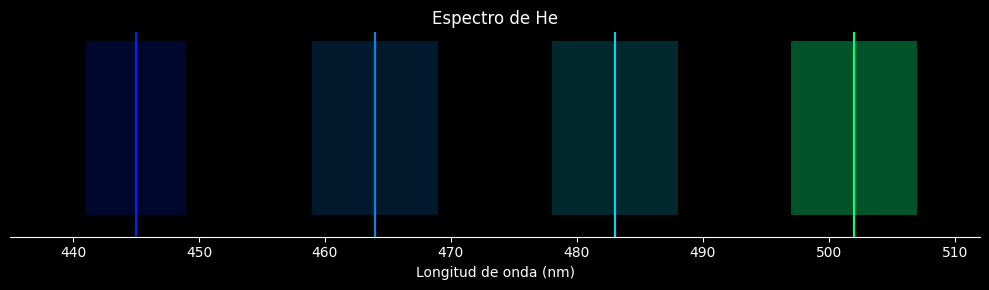

gracias por usar Pumita v3.1415


In [101]:

Lambda_medido = Pumita_v3_1415()

In [ ]:
#Tito_00 = 216,20,15
#tito_01 = 209,00,24
#tito_02 = 208,40,21
#tito_03 = 208,40,18
#tito_04 = 208,20,18
#tito_05 = 208,00,21
#tito_06 = 207,40,18
#tito_07 = 207,40,15
#tito_08 = 206,20,27
#tito_09 = 204,40,18
#tito_10 = 204,20,21

#Tito_00 = 216,20,15
#tito_01 = 209,00,24
#tito_02 = 208,40,21
#tito_03 = 208,40,18
#tito_04 = 208,20,18
#tito_05 = 208,00,21
#tito_06 = 207,40,18
#tito_07 = 207,40,15
#tito_08 = 206,20,27
#tito_09 = 204,40,18
#tito_10 = 204,20,21 
